In [63]:
using JuMP, Plots, Gurobi, BenchmarkTools, JuMPeR, Mosek, Compose, Interact, PiecewiseLinearOpt

## 用Julia进行优化建模及求解 

**Hanzhang Qin (覃含章), Massachusetts Institute of Technology , Julia User Meet Up 2018**

## 0. 为什么要用Julia做优化？

本Tutorial主要介绍JuMP.jl,一种在Julia语言中的开源AML(Algebraic Modeling Language), 类似于AMPL, YALMIP, CVX, Poymo, GAMS等。JuMP的优化建模+solver内存传递速度，与其它商业/开源AML的比较见下表。不涉及Convex.jl，类似Matlab中的CVX，由Boyd et al. 开发的另一种Julia中的AML。

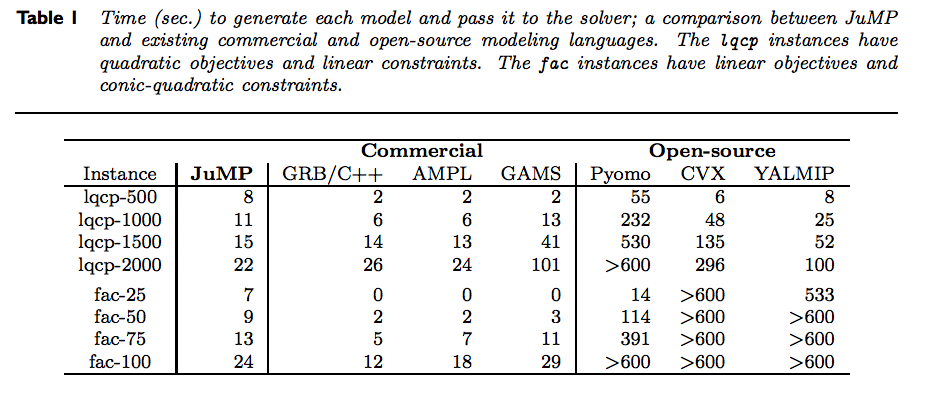

该表来自：Dunning, Iain, Joey Huchette, and Miles Lubin. "JuMP: A modeling language for mathematical optimization." SIAM Review 59.2 (2017): 295-320. 更多JuMP的实现细节和与其它AML的比较可参阅之。

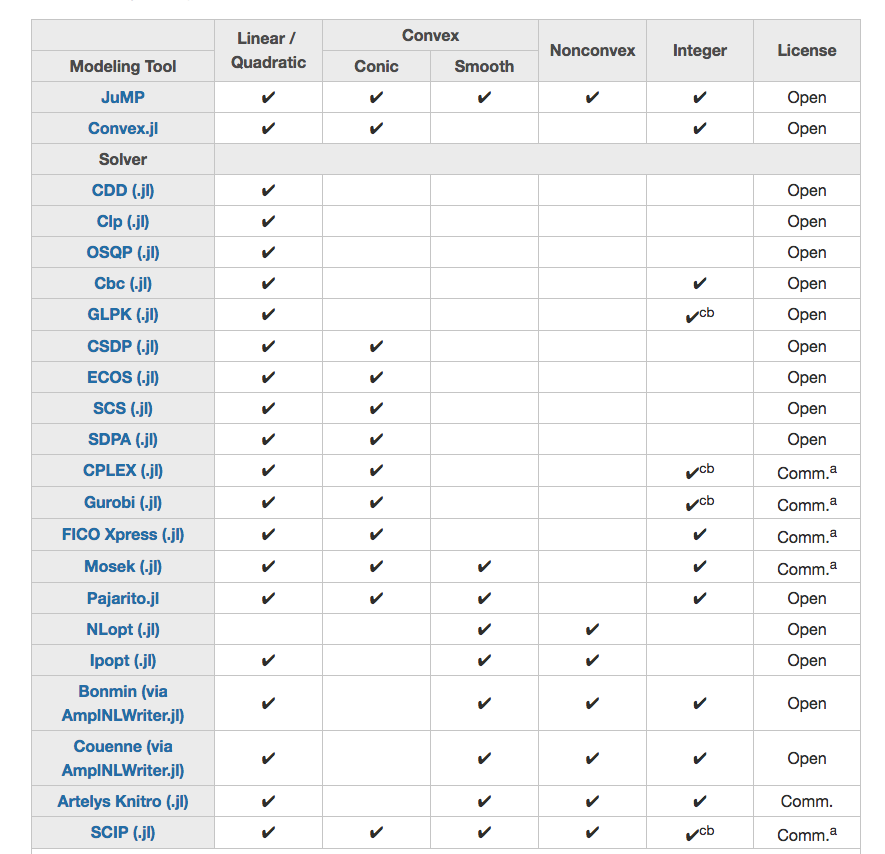

## 1. 优化建模初步（最基本的线性规划）

(这部分主要针对优化理论零基础的听众)

假设你是一个木匠，出售手工制作的木头桌子和木头椅子。现在你想要制定一个生产计划，让这个月的利润最大化。

注意，生产一张桌子，或者一把椅子，都需要消耗一定数量的木材和时间，而作为一个手工小作坊，你每个月能用来生产的时间是有限的，你每个月能进到的木材也是有限的。

简单起见，我们假定桌子的利润固定为一张10元，椅子为一把3元。生产一张桌子需要5单位木材和3单位时间，生产一把椅子需要2单位木材和1单位时间。且我们所有生产的桌子椅子都是能被卖掉的。先假设当月我们总共有200单位木材和90单位时间。

显然，这个生产规划问题可以用线性规划来建模：

\begin{align*}
\max~ & 10x_1+3x_2\tag{P}\\
\text{s.t. } & 5x_1+2x_2\leq 200 \tag{P1}\\
& 3x_1+x_2\leq 90 \tag{P2} \\
& x_1,x_2\geq 0.
\end{align*}

根据对偶理论，我们也知道等价的对偶问题为：

\begin{align*}
\min~ & 200p_1+90p_2 \tag{D}\\
\text{s.t. } & 5p_1+3p_2\geq 10\tag{D1}\\
& 2p_1+p_2\geq 3\tag{D2} \\
& p_1,p_2\geq 0.
\end{align*}

In [16]:
# 利用JuMP求解原问题
function CarpenterPrimal(c,A,b)
    # 定义Model对象, OutputFlag = 0指不输出log
    Primal = Model(solver = GurobiSolver(OutputFlag = 0))
    # 定义变量，注意这里使用了宏（macro），宏的调用也是Julia&JuMP高效编译/元编程(metaprogramming)的重要技巧
    @variable(Primal, x[1:2]>=0)
    # 定义不等式约束
    constr = @constraint(Primal, A*x.<=b)
    # 定义目标函数
    @objective(Primal, Max, dot(c,x))
    # 求解
    solve(Primal)
    # 返回最优目标函数值，最优解（原问题），最优解（对偶问题）
    return getobjectivevalue(Primal), getvalue(x), getdual(constr)
end

CarpenterPrimal (generic function with 1 method)

In [17]:
CarpenterPrimal([10;3],[5 2;3 1],[200;90])

Academic license - for non-commercial use only


(300.0, [30.0, 0.0], [0.0, 3.33333])

最优解是生产30张桌子，不生产椅子：$x_1^*=30, x_2^*=0$。接下来我们看一下这个解背后所蕴含的其他信息。

原问题(P)中变量$x_1,x_2$代表生产桌子和椅子的数量，而在对偶问题(D)中变量$p_1,p_2$代表的是原材料木材和时间的价格，或者说，原问题(P)中约束(P1)和(P2)对应的**影子价格**。

注意之所以叫影子价格，这是因为求解问题(P)的时候我们并没有显式求出对应原材料的价格。然而，我们即将看到，只要求解了原问题，就蕴含了对原材料影子价格的估计。这个估计又蕴含了**互补松弛性**。

为了说明这一点，我们由之前的计算知道(D)的最优解是$p_1^*=0,p_2^*=3.33$，即木材的单位影子价格是0，时间的单位影子价格是3.33，这意味着什么呢？这意味着我们有的木材份量过量了，再增加木材对我们的最优解没有影响（这也是为什么它的影子价格是0），然而我们的时间资源却非常紧俏，哪怕多增加1单位的时间我们的总体利润也能提升（我们可以多生产1/3张桌子...或者说增加3单位时间好了，就可以多生生产1张桌子...）！

对应原问题(P)中，对应木材资源的约束(P1)在最优条件下是松的（不等号严格成立），而(P2)则是紧的（不等号其实是等号）。我们不妨计算得到$5x_1^*+2x_2^*=150<200,3x_1^*+x_2^*=90$，果然如此！

这便是**互补松弛性**的定义。如果在最优条件下一个约束不等式是松的，那么这个约束对应的影子价格为0。反过来说，如果这个约束对应的影子价格严格大于0，那么这个约束不等式一定是紧的。所以，当你解完问题(P)的时候你必然就知道$p_1^*=0$，且(D1)是紧的（因为$x_1^*>0$，注意(P)也是(D)的对偶问题），从而可以直接算出$p_2^*=(10-0)/3$，即不用再放到solver就可以手算出(D)的解。

我们也可以利用JuMP进行敏感度分析（Sensitivity Analysis）。考虑以下四个（P）的变种问题：（当然，其实都可以手解）

(1) 把(P)中的(P1)右端项改成250，即木材总量增加。其余不变。最优解是什么？

(2) 把(P)中的(P2)右端项改成120，即生产时间增加。其余不变。最优解是什么？增加的利润（相比原来的(P)）和（P2）的影子价格的关系？

(3) 假设桌子的单位利润不变，椅子的单位利润增加到多少的时候(P)的最优解开始生产椅子（而不生产桌子）？

(4) 假设时间的总量仍为90，木材的总量减少到多少的时候木材的影子价格严格大于0（时间的影子价格反而变成0）？

In [34]:
# (3)的答案: 当椅子的单位利润增长到10/3
CarpenterPrimal([10;10/3],[5 2;3 1],[200;90])

Academic license - for non-commercial use only


(300.0, [0.0, 90.0], [0.0, 3.33333])

## 2. 线性规划中的Column Generation实例：大规模additive convex regression

给定数据$Y\in \mathbb{R}^n, X\in \mathbb{R}^{n\times d}$, 我们考虑以下线性规划问题：
\begin{align*}
\min~ & \sum_{i=1}^n \left|Y_i-\sum_{j=1}^d f_j(X_{ij})\right|\\
\text{s.t. } & f_j:\mathbb{R}\rightarrow\mathbb{R} \text{ is convex}, \forall~j=1,\ldots, d.
\end{align*}

注意我们如果在目标函数中再额外加上正则项$\lambda\sum_{j=1}^d \left| \sum_{i=1}^n f_j(X_{ij}) \right|$（$\lambda>0$）, 则我们可以得到一个稀疏的(sparse) additive model。详见：Ravikumar, Pradeep, et al. "Sparse additive models." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 71.5 (2009): 1009-1030.

上述模型是线性规划因为等价于(记$[:]_j$为$X_{:j}$升序排序后的对应原index的序列)
\begin{align*}
\min~ & \sum_{i=1}^n r_i^++r_i^-\\
\text{s.t. } & Y_i - \sum_{j=1}^d f_{ij} = r_i^+-r_i^-, \forall~i=1,\ldots,n\\
& (f_{[i]_j j}-f_{[i-1]_j j})(X_{[i+1]_j j}-X_{[i]_j j})\leq (f_{[i+1]_j j}-f_{[i]_j j})(X_{[i]_j j}-X_{[i-1]_j j}),\forall~i=2,\ldots,n-1,\forall~j=1,\ldots,d.
\end{align*}

In [11]:
# 生成样本
n = 5000
d = 2
function_list = [x->0.5*abs.(x).^2,x->2*abs.(x),x->5*x.^2,x->0.5*exp.(x),x->0.3*x,x->0.7*x,x->2*x.^2,x->0.1*exp.(x),x->x.^2,x->exp.(x)]
srand(123)
X = rand(n,d) - 0.5
Y = 0.02*randn(n,1)
for i = 1:d
    Y = Y + function_list[mod(i-1,10)+1](X[:,i])
end

In [12]:
# Full-sized的线性规划模型
function Full_ConvReg(Max_T)
    M_conv_full = Model(solver=GurobiSolver(TimeLimit=Max_T, OutputFlag=0))
    @variable(M_conv_full, f_hat[1:n,1:d])
    @variable(M_conv_full, Res_pos[1:n]>=0)
    @variable(M_conv_full, Res_neg[1:n]>=0)    
    for k = 1:d
        xx = X[:,k] 
        ids = sortperm(vec(xx),rev=false)
        xx = xx[ids]
        for i in 2:(n-1)
            d1 = (xx[i+1]-xx[i]); d2=(xx[i]-xx[i-1]);
            @constraint(M_conv_full, (f_hat[ids[i],k]-f_hat[ids[i-1],k])*d1<=(f_hat[ids[i+1],k]-f_hat[ids[i],k])*d2);
        end   
    end
    
        for i in 1:n
            @constraint(M_conv_full, Y[i] - sum(f_hat[i,k] for k=1:d) == Res_pos[i] - Res_neg[i]  )
        end  
        @objective(M_conv_full, :Min, sum(Res_pos[i] + Res_neg[i] for i = 1:n) )   
        solve(M_conv_full)   
    return getvalue(f_hat)
end

Full_ConvReg (generic function with 1 method)

接下来我们介绍什么是Column Generation，并展示如何对上述问题利用JuMP和Gurobi进行Column Generation。这种方法是基于单纯形法（simplex methopd）的。即我们在一开始默认所有的变量都为0且不是基变量，而在每步iteration的时候利用前一轮的对偶变量的值计算reduced cost(只需要计算一步矩阵和向量的乘法)，并将reduced cost最负的变量加入（成为基变量）。同时注意到，因为原问题的约束矩阵实际上具有分块特性（按照$j=1,\ldots,d$分块），实际上我们可以采取Dantzig-Wolfe的formulation，即利用一个cyclic的update方式，在每个iteration对每个block单独计算reduced cost（比一起算快了$d$倍）。当所有reduced cost非负的时候，找到最优解：算法终止。

In [13]:
# Column Generation化的线性规划模型
function CG_ConvReg(Max_T)
    # build the LO: no Δ included
    M_conv = Model(solver=GurobiSolver(TimeLimit = Max_T,OutputFlag = 0,Method = 0))
    @variable(M_conv, Res_pos[1:n]>=0)
    @variable(M_conv, Res_neg[1:n]>=0)
    @constraintref constr[1:n]
    
    MaxIter = 1000
    
    XX = zeros(n,d)
    L = zeros(n,n+2,d)
    ids = convert(Array{Int64,2},zeros(n,d))
    ids_rec = convert(Array{Int64,2},zeros(n,d))
    
    for k = 1:d
        # sort the sequences
        ids[:,k] = sortperm(vec(X[:,k]),rev=false)
        ids_rec[:,k] = sortperm(ids[:,k],rev=false)
        XX[:,k] = X[ids[:,k],k]  
        # needed for column generation
        L[:,1,k] = ones(n,1)
        L[:,2,k] = -ones(n,1)
        L[2,3,k] = XX[2] - XX[1]
        L[2,4,k] = - XX[2] + XX[1]
        for i = 3:n
            L[i,3,k] = XX[i,k] - XX[1,k]
            L[i,4,k] = - XX[i,k] + XX[1,k]
            L[i,5:i+2,k] = [XX[i,k]-XX[j+1,k] for j=1:i-2]'
        end
        L[:,:,k] = L[ids_rec[:,k],:,k] 
    end
    
    @constraint(M_conv, constr[i=1:n], Res_pos[i] - Res_neg[i] == Y[i])
    @objective(M_conv, :Min, sum(Res_pos[i] + Res_neg[i] for i = 1:n) )
    
    solve(M_conv)
    dual_var = getdual(constr)
                    
    NewColumns = [Variable[] for i=1:d]
    IdxList = [[] for i=1:d]                       
    
    # Implement column generation                 
    iter = 1   
    flag = vec(ones(d,1))
    while sum(flag) > 1e-3 && iter < MaxIter
    #for t = 1:30
    for k = 1:d    
        if flag[k] == 1 
            Δ_r = -L[:,:,k]'*dual_var 
        else
            continue
        end
        if findmin(Δ_r)[1] < -1e-3
            idx = findmin(Δ_r)[2]
            constr_list = constr[1:n]
            coeff_list = L[:,idx,k]
            @variable(M_conv, Δ_temp >= 0, objective = 0., inconstraints = constr_list, coefficients =  coeff_list ) 
            #print("CG iteration ", iter,": enter Δ ",idx," for covariate ",k, "\n")
            push!(NewColumns[k],Δ_temp)
            push!(IdxList[k],idx)
            solve(M_conv) 
            iter = iter + 1
            dual_var = getdual(constr);
        else
            #print("Skip covariate ", k,"\n")
            flag[k] = 0
        end
    end
    end
    #print("CG ends after ", iter-1, " itertaions.\n")
                
    # Retrieve the ϕ values
    delta = zeros(n+2,d)
    zz = zeros(n,d)
    phi = zeros(n,d)
    for k = 1:d
        delta[IdxList[k],k]=getvalue(NewColumns[k])
        if isempty(find(IdxList[k].==2))
                zz[1,k] = delta[1,k]
        else
                zz[1,k] = -delta[2,k]
        end
        if isempty(find(IdxList[k].==4))
                zz[2,k] = delta[3,k]
        else
                zz[2,k] = -delta[4,k]
        end
        phi[1,k] = zz[1,k]
        phi[2,k] = zz[1,k]+zz[2,k]*(XX[2,k]-XX[1,k])                           
        for i = 3:n
            zz[i,k] = zz[i-1,k] + delta[i+2,k]
            phi[i,k] = zz[i,k]*(XX[i,k]-XX[i-1,k])+phi[i-1,k]
        end
    end
    
    return phi
end

CG_ConvReg (generic function with 1 method)

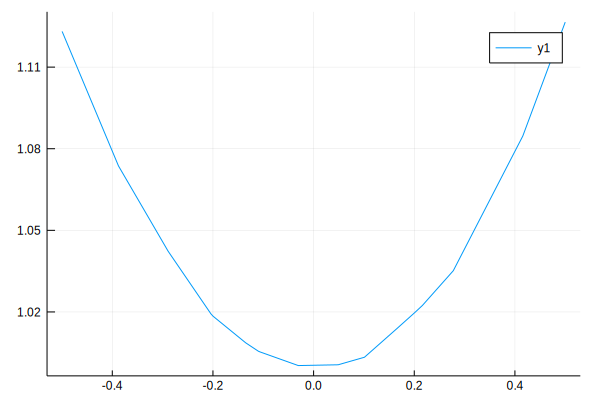

In [14]:
phi = CG_ConvReg(200);
# 画出第一维上的解
XX = zeros(n,d)
ids = convert(Array{Int64,2},zeros(n,d))
ids_rec = convert(Array{Int64,2},zeros(n,d))
    
for k = 1:d 
        # sort the sequences
        ids[:,k] = sortperm(vec(X[:,k]),rev=false)
        ids_rec[:,k] = sortperm(ids[:,k],rev=false)
        XX[:,k] = X[ids[:,k],k] 
end
plot(XX[:,1],phi[:,1])

In [47]:
@benchmark CG_ConvReg(200)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


BenchmarkTools.Trial: 
  memory estimate:  27.61 GiB
  allocs estimate:  96714063
  --------------
  minimum time:     32.205 s (10.13% GC)
  median time:      32.205 s (10.13% GC)
  mean time:        32.205 s (10.13% GC)
  maximum time:     32.205 s (10.13% GC)
  --------------
  samples:          1
  evals/sample:     1

In [49]:
@benchmark Full_ConvReg(600)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


BenchmarkTools.Trial: 
  memory estimate:  25.40 MiB
  allocs estimate:  449043
  --------------
  minimum time:     361.135 s (0.00% GC)
  median time:      361.135 s (0.00% GC)
  mean time:        361.135 s (0.00% GC)
  maximum time:     361.135 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

令人惊讶的是，基于古老的单纯形法和Column Generation的算法竟然要远快于Gurobi求解LP默认的non-deterministic concurrent方法！这证明针对特定的优化问题，有时候更聪明的建模会给你更快的算法。

## 3. 鲁棒线性规划（Robust Linear Programming）

我们考虑最小费用流问题（minimum cost flow），其中每条边上的cost具有不确定性（uncertainty）。即我们考虑一个有向图$G=(V,E)$，$V=\{1,\ldots,n\}$,我们考虑优化问题：
\begin{align*}
\min~ & \sum_{(i,j)\in E} c_{ij}x_{ij}\\
\text{s.t. } & \sum_{(1,i)\in E}x_{1i} = 1\\
& \sum_{(i,n)\in E}x_{in} = 1\\
& \sum_{(i,j)\in E}x_{ij} = \sum_{(j,k)\in E} x_{jk},\forall~j\in V \backslash \{1,n\}\\
& 0\leq x_{ij}\leq C_{ij}.
\end{align*}

In [15]:
# Nominal Problem
function NominalProblem(n,μ,δ)
    NetworkModel = Model(solver=GurobiSolver(OutputFlag=0))
    capacity = (ones(n,n)-eye(n,n))*0.5
    capacity[1,n] = 0
    capacity[n,1] = 0
    @variable(NetworkModel, flow[i=1:n,j=1:n]>=0)
    @constraint(NetworkModel, flow .<= capacity)
    @constraint(NetworkModel, sum(flow[1,i] for i=1:n)==1)
    @constraint(NetworkModel, sum(flow[i,n] for i=1:n)==1)
    for j = 2:n-1
        @constraint(NetworkModel, sum(flow[i,j] for i=1:n) == sum(flow[j,k] for k=1:n)  )
    end
    @objective(NetworkModel,Min, sum(flow[i,j]*μ[i,j] for i=1:n for j=1:n) );
    solve(NetworkModel)
    return getvalue(flow)
end

NominalProblem (generic function with 1 method)

我们考虑以下三种uncertainty set:
\begin{align*}
& (i)~\text{Box Uncertainty}: \mathcal{U}_{L_\infty} = \{\textbf{c}:μ_{ij}-\delta_{ij}\gamma_{ij}\leq c_{ij}\leq \mu_{ij}+\delta_{ij}\gamma_{ij}, \|\gamma\|_{\infty}\leq \Gamma \}\\
& (ii)~\text{Polyhedral Uncertainty}: \mathcal{U}_{L_1} = \{\textbf{c}:μ_{ij}-\delta_{ij}\gamma_{ij}\leq c_{ij}\leq \mu_{ij}+\delta_{ij}\gamma_{ij}, \|\gamma\|_1\leq \Gamma \}\\
& (iii)~\text{Elliopsoidal Uncertainty}: \mathcal{U}_{L_2} = \{\textbf{c}:μ_{ij}-\delta_{ij}\gamma_{ij}\leq c_{ij}\leq \mu_{ij}+\delta_{ij}\gamma_{ij}, \|\gamma\|_2\leq \Gamma \}\\
\end{align*}

其实，容易知道(i)(ii)的robust min cost flow问题仍可写成一个线性规划，(iii)的robust min cost flow问题可写成一个二阶锥规划问题(second-order cone optimization)。不过我们这里展示利用JuMPeR包可以省去推导robust counterpart的步骤。

In [16]:
# Robust Problem
function RobustProblem(n,μ,δ,Γ,norm_type)
    NetworkModel_robust = RobustModel(solver=GurobiSolver(OutputFlag=0))
    capacity = (ones(n,n)-eye(n,n))*0.5
    capacity[1,n] = 0
    capacity[n,1] = 0
    @variable(NetworkModel_robust, flow[i=1:n,j=1:n]>=0)
    @uncertain(NetworkModel_robust, cost[i=1:n,j=1:n])
    @uncertain(NetworkModel_robust, r[i=1:n,j=1:n])
    @variable(NetworkModel_robust, obj) 
    for i = 1:n
        for j = 1:n
        @constraint(NetworkModel_robust, cost[i,j] == μ[i,j]+r[i,j]*δ[i,j])
        end
    end  
    @constraint(NetworkModel_robust, norm(r,norm_type) <= Γ)
    @constraint(NetworkModel_robust, flow .<= capacity)
    @constraint(NetworkModel_robust, sum(flow[1,i] for i=1:n) == 1)
    @constraint(NetworkModel_robust, sum(flow[i,n] for i=1:n) == 1)
    for j = 2:n-1
        @constraint(NetworkModel_robust, sum(flow[i,j] for i=1:n) == sum(flow[j,k] for k=1:n))
    end
    @constraint(NetworkModel_robust, sum(cost[i,j]*flow[i,j] for i=1:n for j=1:n) <= obj )
    @objective(NetworkModel_robust, Min, obj)
    solve(NetworkModel_robust)
    return getvalue(flow)
end

RobustProblem (generic function with 1 method)

我们这里做一些仿真来看一下robust solution的表现。假设G是完全连同的，所有边的容量都是0.5，我们随机产生$\mu_{ij}\sim Uniform(0,10),\delta_{ij}\sim Uniform(0,\mu_{ij})$，然后我们再随机产生$c_{ij}\sim Normal(\mu_{ij},\delta_{ij})$来看实际的cost的情况。我们以nominal problem的解为benchmark,输出robust solution的cost与其的差。

In [17]:
function Evaluation()
    n_type = [10,25,50,75,100]
    Γ_type = [1e-4,1e-1,1e1,1e4]
    report_data = zeros(13,5)
    for n_idx = 1:5
        n = n_type[n_idx]
        count = 2
        μ = 10*rand(n,n)
        δ = zeros(n,n)
        for i = 1:n
            for j = 1:n
                δ[i,j] = μ[i,j]*rand()
            end
        end
        cost_sim = zeros(n,n)
                for i = 1:n
                    for j = 1:n
                        cost_sim[i,j] = μ[i,j] + δ[i,j] * (rand()-0.5) * 2
                    end
                end
        sol_0 = NominalProblem(n,μ,δ)
        report_data[1,n_idx] = sum(sum(cost_sim.*sol_0))
        for Γ in Γ_type
            print("n=",n," Γ=",Γ)
            sol_inf = RobustProblem(n,μ,δ,Γ,Inf)
            sol_1 = RobustProblem(n,μ,δ,Γ,1)
            sol_2 = RobustProblem(n,μ,δ,Γ,2)    
            report_data[count,n_idx] = sum(sum(cost_sim.*(sol_inf-sol_0)))
            report_data[count+1,n_idx] = sum(sum(cost_sim.*(sol_1-sol_0) ))
            report_data[count+2,n_idx] = sum(sum(cost_sim.*(sol_2-sol_0) ))
            count = count + 3
        end
    end
    return report_data
end

Evaluation (generic function with 1 method)

In [ ]:
output = Evaluation();

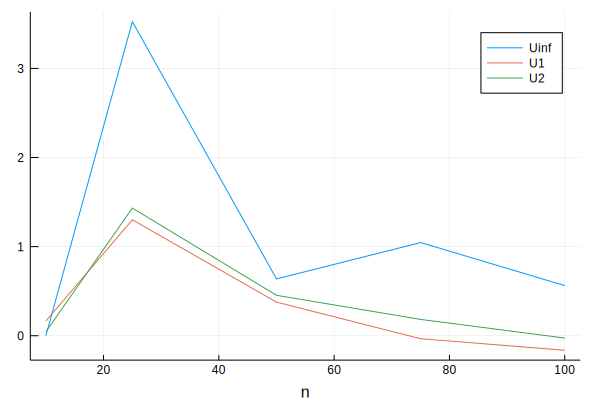

100 Γ=10000.0

In [19]:
# 输出Γ=10时三种uncertainty set给出的difference
temp_p = plot([10,25,50,75,100],output[8,:],xlabel = "n", label = "Uinf")
plot!(temp_p,[10,25,50,75,100],output[9,:], label = "U1")
plot!(temp_p,[10,25,50,75,100],output[10,:], label = "U2")

JuMPeR也可以model多阶段的鲁棒优化问题，尤其比如是affinely-adjustable policy的(这比uncertainty set的formulation要松的多)。这里只是提一下，不详细介绍了。

## 4. 近似解Stable Number: 半正定规划/整数规划

一个无向图 $G=(V,E)$ 的 $\textbf{stable}$ (independent) set 是V的一个子集，其中所有节点互相都不相连。 stable set的最大cardinality定义为$\alpha(G)$ ，也叫做图的stability number. 假设 $|V|=n$. 自然，其0/1整数规划可以写成：
\begin{align}
\alpha(G) = & \max_x~ \sum_{i=1}^n x_i\\
&\text{s.t. } x_i+x_j\leq 1,~ \text{if } (i,j)\in E,\\
& x_i\in \{0,1\},\forall~i=1,\ldots,n.
\end{align}

利用 $x_i+x_j\leq 1$ 和$x_ix_j=0$ 等价， 我们可以得到一个半正定规划的relaxation：
\begin{align}
\alpha(G) = & \max_X~ \text{tr}(ee^TX)  \\
&\text{s.t. } X_{ij} = 0,~ \text{if } (i,j)\in E,\\
& \text{tr}(X) = 1,\\
& X\succeq 0,\\
& X\geq 0.
\end{align}

例子来源：Pena, Javier, Juan Vera, and Luis F. Zuluaga. "Computing the stability number of a graph via linear and semidefinite programming." SIAM Journal on Optimization 18.1 (2007): 87-105

In [38]:
function StableBin(A)
    n = size(A,1)
    StableB = Model(solver = GurobiSolver(OutputFlag = 0))
    @variable(StableB, x[1:n], Bin)
    for i = 1:n
        for j in find(A[i,:].== 1)
            @constraint(StableB, x[i] + x[j] <= 1)
        end
    end
    @objective(StableB, Max, sum(x))
    solve(StableB)
    return getobjectivevalue(StableB)
end

StableBin (generic function with 1 method)

In [39]:
function StableSDP(A)
    n = size(A,1)
    StableDD = Model(solver = MosekSolver(MSK_IPAR_LOG = 0))
    @variable(StableDD, X[1:n,1:n])
    @SDconstraint(StableDD, X>=0)
    @constraint(StableDD, X.>=0)
    @constraint(StableDD, sum(sum(A.*X)) == 0 )
    @constraint(StableDD, sum(X[i,i] for i=1:n) == 1)
    @objective(StableDD, Max, sum(sum(X)))
    solve(StableDD)
    return getobjectivevalue(StableDD)
end

StableSDP (generic function with 1 method)

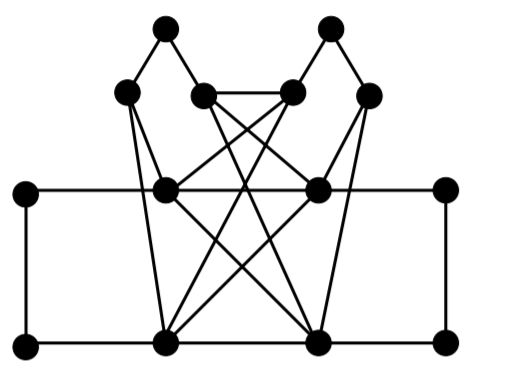

In [47]:
# α(G14) = 5
A14 = [0 1 1 0 0 0 0 0 0 0 0 0 0 0; 
       1 0 0 1 0 0 0 0 0 0 0 0 0 0;
       1 0 0 0 1 1 0 0 1 0 0 1 0 0;
       0 1 0 0 1 1 0 0 1 0 0 1 0 0;
       0 0 1 1 0 0 1 0 0 0 1 0 0 1;
       0 0 1 1 0 0 0 1 0 0 1 0 0 1;
       0 0 0 0 0 1 0 1 0 0 0 0 0 0;
       0 0 0 0 0 1 1 0 0 0 0 0 0 0;
       0 0 1 1 0 0 0 0 0 1 0 0 0 0;
       0 0 0 0 0 0 0 0 1 0 1 0 0 0;
       0 0 0 0 1 1 0 0 0 1 0 1 0 0;
       0 0 1 1 0 0 0 0 0 0 1 0 1 0;
       0 0 0 0 0 0 0 0 0 0 0 1 0 1;
       0 0 0 0 1 1 0 0 0 0 0 0 1 0];
StableBin(A14)

5.0

Academic license - for non-commercial use only


In [62]:
# 松弛之后的解
StableSDP(A14)

5.694362954824882

## 5. Lazy Constriant Generation: 在整数规划中用分段线性函数近似L2球

我们指出Gurobi还暂不支持整数规划和column generation结合（即branch and price）,然而自定义user cut确是支持的（即branch and cut）！简单来说，即我们可以一开始只加入少量的约束，在一边求解整数规划的过程中将被violate的约束加入，因此也叫lazy callback。

这个例子来自于：https://github.com/JuliaOpt/juliaopt-notebooks/blob/master/notebooks/JuMP-LazyL2Ball.ipynb

我们要求解的问题是一个整数约束的二阶锥规划问题：
\begin{align*}
\max ~ & c^T x\\
\text{s.t. } & \|x\|_2\leq \Gamma,\\
& x\in \mathbb{Z}^n.
\end{align*}

In [33]:
function solve_ball(c, Γ, ϵ=1e-6)
    n = length(c)
    m = Model(solver=GurobiSolver(OutputFlag=0))
    # 初始consrtaint: 一个box
    @variable(m, -Γ ≤ x[1:n] ≤ Γ, Int)
    # 定义目标函数
    @objective(m, Max, dot(c,x))
    #核心：定义callback function，记录加入cut的数量
    num_callbacks = 0
    function norm_callback(cb)
        num_callbacks += 1
        N = getvalue(x)
        # 求得当前x的L2 norm
        L = norm(N)
        # 如果足够小，说明已经得到一个可行解，即解最优
        if L ≤ Γ + ϵ
            return
        end
        # 不然的话，加入cut!注意这个cut将使得x变得不可行（infeasible），下步迭代必然会得到一个新的解
        @lazyconstraint(cb, dot(N,x) ≤ Γ*L)
    end
    # 将callback函数加入JuMP/Gurobi模型
    addlazycallback(m, norm_callback)
    
    #求解
    solve(m)
    return getvalue(x), num_callbacks
end

#产生一个随机样例
srand(1234)
n = 2
c = rand(n)
Γ = 50.0

# 求解，输出callback次数
sol, num_callbacks = solve_ball(c, Γ)
println(sol)
println(norm(sol))
println(num_callbacks)

Academic license - for non-commercial use only
[30.0, 40.0]
49.99999999999999
11


Interact.Options{:SelectionSlider,Float64}(9: "input-4" = 0.0 Float64 , "c1", 0.0, "0.0", 11, Interact.OptionDict(DataStructures.OrderedDict("-1.0"=>-1.0,"-0.9"=>-0.9,"-0.8"=>-0.8,"-0.7"=>-0.7,"-0.6"=>-0.6,"-0.5"=>-0.5,"-0.4"=>-0.4,"-0.3"=>-0.3,"-0.2"=>-0.2,"-0.1"=>-0.1…), Dict(1.0=>"1.0",0.3=>"0.3",-0.2=>"-0.2",-1.0=>"-1.0",-0.3=>"-0.3",-0.6=>"-0.6",0.7=>"0.7",0.0=>"0.0",0.2=>"0.2",-0.1=>"-0.1"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:SelectionSlider,Float64}(11: "input-5" = 0.0 Float64 , "c2", 0.0, "0.0", 11, Interact.OptionDict(DataStructures.OrderedDict("-1.0"=>-1.0,"-0.9"=>-0.9,"-0.8"=>-0.8,"-0.7"=>-0.7,"-0.6"=>-0.6,"-0.5"=>-0.5,"-0.4"=>-0.4,"-0.3"=>-0.3,"-0.2"=>-0.2,"-0.1"=>-0.1…), Dict(1.0=>"1.0",0.3=>"0.3",-0.2=>"-0.2",-1.0=>"-1.0",-0.3=>"-0.3",-0.6=>"-0.6",0.7=>"0.7",0.0=>"0.0",0.2=>"0.2",-0.1=>"-0.1"…)), Any[], Any[], true, "horizontal", true)

Interact.Options{:SelectionSlider,Int64}(13: "input-6" = -1 Int64 , "logϵ", -1, "-1", 4, Interact.OptionDict(DataStructures.OrderedDict("-4"=>-4,"-3"=>-3,"-2"=>-2,"-1"=>-1,"0"=>0,"1"=>1,"2"=>2), Dict(0=>"0",-4=>"-4",-3=>"-3",2=>"2",-2=>"-2",-1=>"-1",1=>"1")), Any[], Any[], true, "horizontal", true)

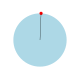

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [34]:
# 这里展示Interact和Compose包，可用来进行交互
# 画出2D情况下的解
set_default_graphic_size(8cm, 8cm)

@manipulate for c1 in -1:0.1:+1, c2 in -1:0.1:+1, logϵ in -4:2
    sol, _ = solve_ball([c1,c2], 100, 10.0^logϵ)

    compose(context(),
    compose(context(),
            line([(0.5,0.5),(0.5+sol[1]/300,0.5+sol[2]/300)]),
            Compose.stroke("black")),
    compose(context(),
            circle((0.5 + (100/norm(sol))*sol/300)...,0.02),
            fill("red")),
    compose(context(),circle(0.5,0.5,0.333),fill("lightblue"))
    )
end

## 6. 一般的非线性整数规划：密堆积球问题

我们考虑这样一个问题：有$k$个半径为$r$的球和一个尺寸$d_1\times d_2$的长方形盒子，是否有办法将这些球塞入长方形？显然，一个更一般的问题是对任意长方形找到最大的$k$。不过这个一般的问题可以通过顺序求解（不断增大$k$）之前的决策问题来解决，所以我们就讨论给定$k$的决策问题。

定义变量$(p_1^1,\ldots,p_k^1)$, $(p_1^2,\ldots,p_k^2)$ 为圆心的x和y坐标. 那么决策问题可以用如下非凸非线性规划问题来求解, 也见：Birgin, Ernesto G., J. M. Martınez, and Débora P. Ronconi. "Optimizing the packing of cylinders into a rectangular container: a nonlinear approach." European Journal of Operational Research 160.1 (2005): 19-33.
\begin{align}
\min~ & \sum_{i\neq j\in \{1,\ldots, k\} } \max\left(0,2r - \sqrt{(p_i^1-p_j^1)^2+(p_i^2-p_j^2)^2} \right)\\
\text{s.t. } & r\leq p_1^i\leq d_1-r,\forall~ i=1,\ldots,k, \\
& r\leq p_2^i\leq d_2-r,\forall~ i=1,\ldots,k. \\
\end{align}

和上一节思路类似，我们这里也利用分段线性函数和整数规划来近似这里的L2函数。当然，我们这里采取更一般的做法，利用PiecewiseLinear包来方便完成。具体来说，我们考虑用整数线性规划近似如下非线性规划中的非凸约束。

\begin{align}
\min~ & \sum_{i\neq j\in \{1,\ldots, k\} } z_{ij}\\
\text{s.t. } & z_{ij}\geq 2r - \sqrt{(p_i^1-p_j^1)^2+(p_i^2-p_j^2)^2}, \forall ~ i\neq j\in \{1,\ldots,k\},\\
&r\leq p_1^i\leq d_1-r,\forall~ i=1,\ldots,k, \\
& r\leq p_2^i\leq d_2-r,\forall~ i=1,\ldots,k. \\
& z_{ij}\geq 0, \forall ~ i\neq j\in \{1,\ldots,k\}.
\end{align}

In [29]:
# 画图
function PlotCirclesRectangle(p1,p2)
    p = scatter((p2),(p1))
    for i = 1:k
        plot!(p,(p2[i]).+r*cos.(linspace(0,2*π,100)), (p1[i]).+r*sin.(linspace(0,2*π,100)), color = "blue", legend=false, aspect_ratio = 1 )
    end
    plot!(p,linspace(0,d2,100),zeros(100,1),color = "red")
    plot!(p,zeros(100,1),linspace(0,d1,100),color = "red")
    plot!(p,linspace(0,d2,100),ones(100,1)*d1,color = "red")
    plot!(p,d2*ones(100,1),linspace(0,d1,100),color = "red")
    p
end

PlotCirclesRectangle (generic function with 1 method)

In [24]:
# 考虑这样一组问题
r = 25
d1 = 160
d2 = 190
k = 11;

In [28]:
# MIO
function PackCirclesGen(r,d1,d2,k,Method,MaxTime)
    tic()
    PackCircles = Model(solver = GurobiSolver(MIPGap = 1e-3, OutputFlag = 0, TimeLimit = MaxTime))
    @variable(PackCircles, p1[1:k]>=r)
    @variable(PackCircles, p2[1:k]>=r)
    @variable(PackCircles, s1[1:k,1:k])
    @variable(PackCircles, s2[1:k,1:k]>=0)
    @variable(PackCircles, z[1:k,1:k]>=0)

    @constraint(PackCircles, p1.<=d1-r)
    @constraint(PackCircles, p2.<=d2-r)

    for i = 1:k
        for j = i+1:k
        if j - i > 2 
            continue
        end
        @constraint(PackCircles,s1[i,j] == p1[j]-p1[i])
        @constraint(PackCircles,s2[i,j] == p2[j]-p2[i])
        #使用PiecewiseLinearOpt包近似nonconvex constraint
        fun_dist = piecewiselinear(PackCircles, s1[i,j] , s2[i,j], -(j-i)*r*2:r/5:(j-i)*r*2, 0:r/5:(j-i)*r*2, (u,v) -> (u^2+v^2)^0.5, method=Method)
        @constraint(PackCircles, z[i,j] >=  2*r - fun_dist )
        end
    end
    @objective(PackCircles, Min, sum(z[i,j] for i = 1:k for j = i+1:k))
    solve(PackCircles)
    return getvalue(p1),getvalue(p2),toc()
end

PackCirclesGen (generic function with 1 method)

In [ ]:
p1,p2,time = PackCirclesGen(r,d1,d2,k,:ZigZagInteger,Inf);

Academic license - for non-commercial use only 

elapsed time: 1926.175164049 seconds

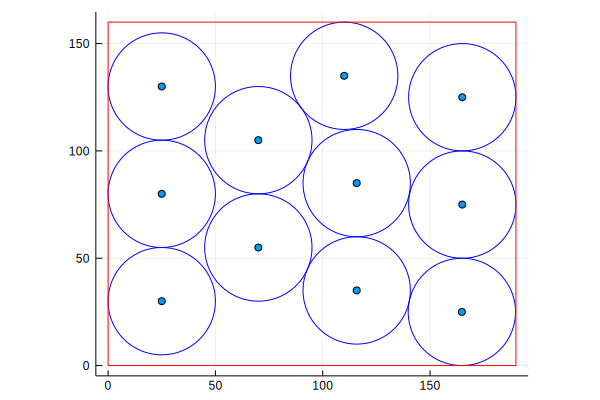

In [30]:
# 一个可行解
PlotCirclesRectangle(p1,p2)

In [ ]:
# 不同bivariate分段线性方法的比较
r = 21
d1 = 120
d2 = 120
k = 6;
Method_List = [:CC,:MC,:DisaggLogarithmic,:SOS2,:Logarithmic,:ZigZag,:ZigZagInteger]
# The experiment, note the cutoff time set as 600 seconds
for Method in Method_List
    p1,p2,time = PackCirclesGen(r,d1,d2,k,Method,600)
    print("The method ", Method, " uses ", time, " seconds!\n")
end

Academic license - for non-commercial use only

elapsed time: 600.508336198 seconds

The method CC uses 600.508336198 seconds!

Academic license - for non-commercial use only

elapsed time: 600.591189729 seconds

The method MC uses 600.591189729 seconds!

Academic license - for non-commercial use only

elapsed time: 105.778549334 seconds

The method DisaggLogarithmic uses 105.778549334 seconds!

Academic license - for non-commercial use only

elapsed time: 16.579328 seconds

The method SOS2 uses 16.579328 seconds!

Academic license - for non-commercial use only

elapsed time: 10.782725926 seconds

The method Logarithmic uses 10.782725926 seconds!

Academic license - for non-commercial use only

elapsed time: 4.313672691 seconds

The method ZigZag uses 4.313672691 seconds!

Academic license - for non-commercial use only

elapsed time: 11.989888395 seconds

The method ZigZagInteger uses 11.989888395 seconds!

详细的理论方法请见：Huchette, Joey, and Juan Pablo Vielma. "Nonconvex piecewise linear functions: Advanced formulations and simple modeling tools."

## 7. 更多

其它JuMP支持的优化拓展包可见：https://www.juliaopt.org/packages/

比如，支持多目标优化的MultiJuMP.jl，机会约束（chance constraint）的JuMPChance.jl，多项式（polynomial）优化的
PolyJuMP.jl，还有支持随机动态规划，非线性控制，平衡约束问题，图论算法，元启发式算法等等的package。

多练，多尝试...Practice makes Perfect!

任何问题，或者交流，欢迎联系hanzhangqin8@gmail.com